# Stock Analysis Data Science Project on S&P 500 stock data

Stock market data can be interesting to analyze and can be useful with good prediction models. While there's a lot of financial data online, finding a large, well-organized dataset for many companies is tough.

This project uses a dataset of 5 years of historical stock prices for all companies in the S&P 500 index.

## Importing Libraries & Uploading Dataset

In [6]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("camnugent/sandp500")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\LapStore\.cache\kagglehub\datasets\camnugent\sandp500\versions\4


In [8]:
import os

# List files in the downloaded directory to find the correct CSV file path
downloaded_files = os.listdir(path)
print("Files in downloaded directory:", downloaded_files)

Files in downloaded directory: ['all_stocks_5yr.csv', 'getSandP.py', 'individual_stocks_5yr', 'merge.sh']


In [9]:
csv_file_path = path + '/all_stocks_5yr.csv'
df = pd.read_csv(csv_file_path)
display(df.head())

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [11]:
df['date'] = pd.to_datetime(df['date'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


In [13]:
print(df.isnull().sum())

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64


In [14]:
df_clean = df.dropna()

In [15]:
print(df_clean.isnull().sum())

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64


In [16]:
df_clean.duplicated().sum()

0

In [17]:
df_clean.describe(include = ['float64' , 'int64'])

,open,high,low,close,volume
count,619029.000000,619029.000000,619029.000000,619029.000000,6.190290e+05
mean,83.023334,83.778419,82.256200,83.043305,4.321892e+06
std,97.378769,98.207735,96.507634,97.388913,8.693671e+06
min,1.620000,1.690000,1.500000,1.590000,1.010000e+02
25%,40.220000,40.620000,39.830000,40.240800,1.070351e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082165e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284550e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


# Exploratory Data Analysis (Visualizations)



## 1. Line chart for close price over time for Top 5 stocks

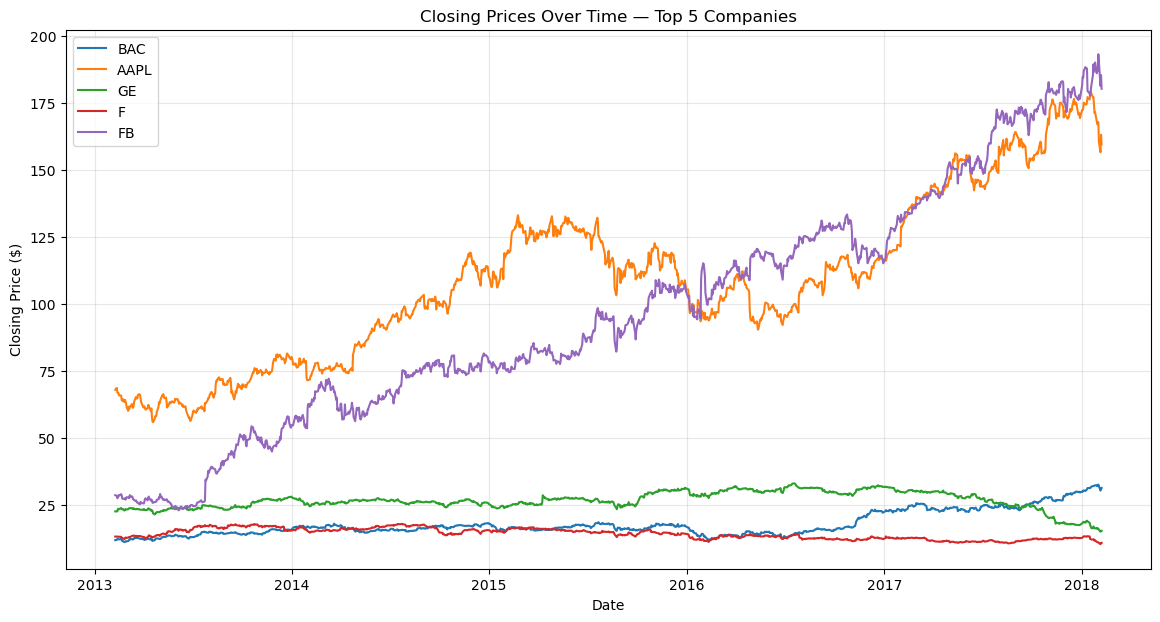

In [18]:
top5 = (df_clean.groupby('Name')['volume']
         .sum()
         .sort_values(ascending=False)
         .head(5)
         .index.tolist())
plt.figure(figsize=(14,7))
for name in top5:
    df_stock = df_clean[df_clean['Name'] == name]
    plt.plot(df_stock['date'], df_stock['close'], label=name, linewidth=1.5)

plt.title('Closing Prices Over Time — Top 5 Companies')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


From this line chart , we see that tech companies (AAPL, FB) greatly outperformed financial and industrial ones (BAC, GE, F).

## 2. Bar chart for volume over time for top 5 stocks

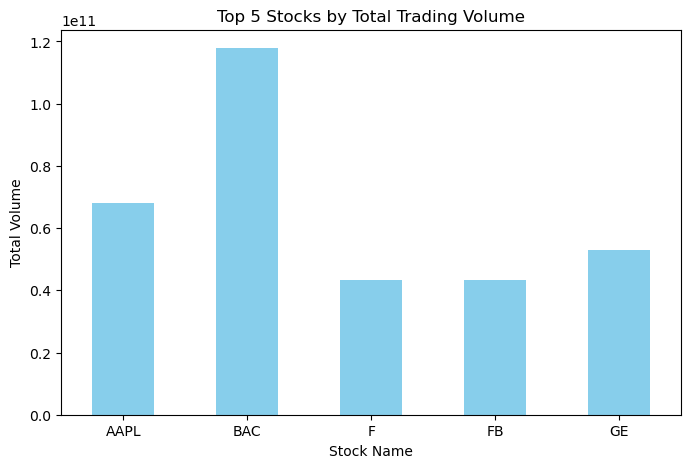

In [19]:
# Get total volume for the top 5 stocks
top5_volume = df_clean[df_clean['Name'].isin(top5)].groupby('Name')['volume'].sum()

# Bar plot
plt.figure(figsize=(8,5))
top5_volume.plot(kind='bar', color='skyblue')
plt.title('Top 5 Stocks by Total Trading Volume')
plt.xlabel('Stock Name')
plt.ylabel('Total Volume')
plt.xticks(rotation=0)
plt.show()


This bar chart shows that trading activity varies significantly among the top 5 stocks. BAC has the highest volume, indicating strong investor interest, while F and FB show relatively low activity. This suggests that certain stocks attract more attention than others.

# Feature Engineering (Creating technical Indicators)



Feature Engineering helps to derive some valuable features from the existing ones. These extra features sometimes help in increasing the performance of the model significantly and certainly help to gain deeper insights into the data.

In [20]:
df_clean.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')

In [21]:
# Sorting by date
df_clean = df_clean.sort_values(["Name", "date"]).reset_index(drop=True)

### 1. SMA (Simple Moving Average) :
#### Average Price over last N days , it helps us to see general changes (trends) of the stock

In [22]:
sma_windows = [20, 50]

# Calculate SMAs
# Use reset_index() to align the index before assigning
df_clean["SMA_20"] = df_clean.groupby('Name')["close"].rolling(window=20).mean().reset_index(level=0, drop=True)
df_clean["SMA_50"] = df_clean.groupby('Name')["close"].rolling(window=50).mean().reset_index(level=0, drop=True)

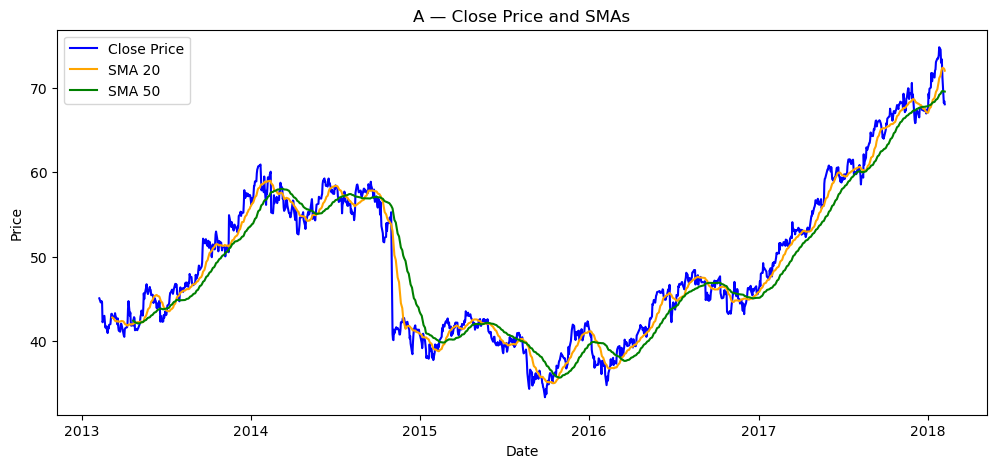

In [23]:
# Example for the first stock in our  dataset
stock_name = df_clean['Name'].unique()[0]
stock_df = df_clean[df_clean['Name'] == stock_name]

plt.figure(figsize=(12,5))
plt.plot(stock_df['date'], stock_df['close'], label='Close Price', color='blue')
plt.plot(stock_df['date'], stock_df['SMA_20'], label='SMA 20', color='orange')
plt.plot(stock_df['date'], stock_df['SMA_50'], label='SMA 50', color='green')
plt.title(f"{stock_name} — Close Price and SMAs")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


When SMA 20 crosses above SMA 50, it signals a bullish trend; when it crosses below, it signals a bearish trend.


The SMAs smooth short-term noise, making overall trend direction and momentum changes clearer.



### 2. Relative Strength Index (RSI):
#### A number between 0-100 that indicates how fast and how much a stock has been going up vs down over a period.
Traders usually use 14-day RSI , so this is what we will use as a feature.


If RSI > 70  (High-RSI) → stock is "overbought" → could drop soon.

If RSI < 30 (Low-RSI) → stock is "oversold"  → could rise soon





Overbought: The stock went up too fast → many people may start selling to take profits → price might fall or stop rising.

Oversold: The stock went down too fast → many people may start buying because it looks cheap → price might rise or stop falling.


In [24]:
df_clean = df_clean.sort_values(['Name', 'date'])

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # EMA Smoothing
    avg_gain = gain.ewm(com=period-1, adjust=False).mean()
    avg_loss = loss.ewm(com=period-1, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Drop first `period` rows which are unstable
    rsi[:period] = np.nan

    return rsi

# Group by stock and calculate RSI_14
df_clean['RSI_14'] = df_clean.groupby('Name')['close'].transform(lambda x: compute_rsi(x, period=14))

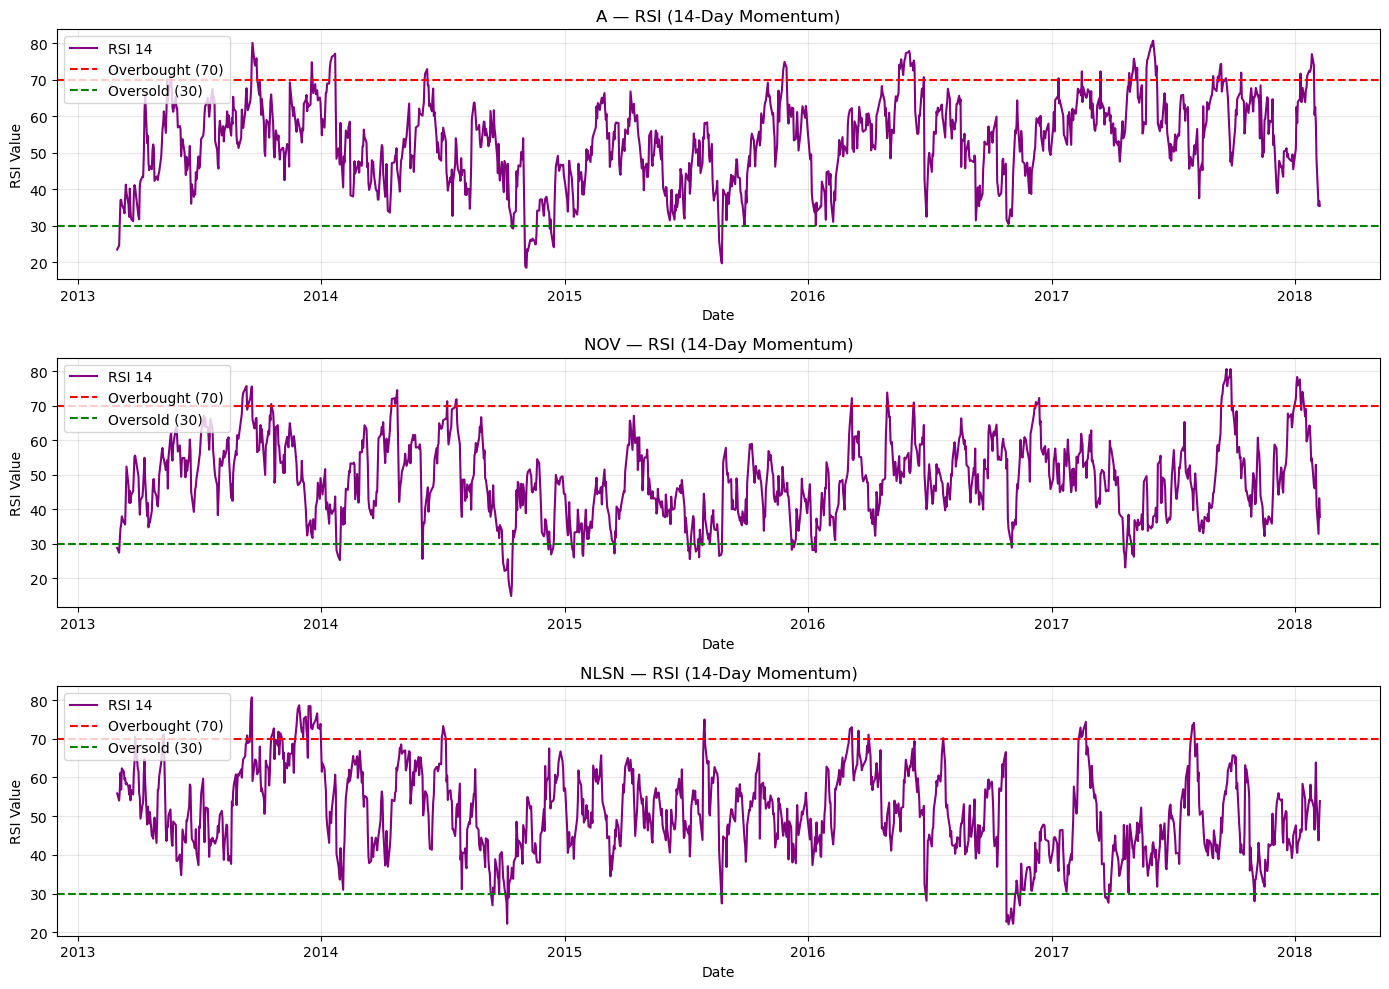

In [ ]:

# Select top 3 stocks (by trading volume or first 3 alphabetically)
top_stocks = df_clean['Name'].value_counts().head(3).index

plt.figure(figsize=(14, 10))

for i, stock in enumerate(top_stocks, 1):
    stock_df = df_clean[df_clean['Name'] == stock]

    plt.subplot(len(top_stocks), 1, i)
    plt.plot(stock_df['date'], stock_df['RSI_14'], color='purple', label='RSI 14')
    plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    plt.title(f"{stock} — RSI (14-Day Momentum)")
    plt.xlabel("Date")
    plt.ylabel("RSI Value")
    plt.legend(loc='upper left')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Each subplot shows the momentum strength of a stock over time.

RSI above 70 (red line) → stock may be overbought, signaling a possible price correction.

RSI below 30 (green line) → stock may be oversold, signaling a potential price rebound.

Frequent swings between 30–70 indicate volatile market behavior, while smoother movements show steady trends.

In [26]:
df_clean.head(15)

,date,open,high,low,close,volume,Name,SMA_20,SMA_50,RSI_14
0,2013-02-08,45.07,45.350,45.000,45.08,1824755,A,NaN,NaN,NaN
1,2013-02-11,45.17,45.180,44.450,44.60,2915405,A,NaN,NaN,NaN
2,2013-02-12,44.81,44.950,44.500,44.62,2373731,A,NaN,NaN,NaN
3,2013-02-13,44.81,45.240,44.680,44.75,2052338,A,NaN,NaN,NaN
4,2013-02-14,44.72,44.780,44.360,44.58,3826245,A,NaN,NaN,NaN
5,2013-02-15,43.48,44.240,42.210,42.25,14657315,A,NaN,NaN,NaN
6,2013-02-19,42.21,43.120,42.210,43.01,4116141,A,NaN,NaN,NaN
7,2013-02-20,42.84,42.850,42.225,42.24,3873183,A,NaN,NaN,NaN
8,2013-02-21,42.14,42.140,41.470,41.63,3415149,A,NaN,NaN,NaN
9,2013-02-22,41.83,42.070,41.580,41.80,3354862,A,NaN,NaN,NaN


We see that RSI_14 is NaN at the first 14 rows of each stock and that's normal because it only calculates starting from the 14th day period.

###3. Volatility:
#### Measures how much a stock’s price fluctuates over a recent period (20 or 50 days).
#### A higher value means the stock is more “unstable” or risky, while a lower value means it moves more steadily.

In [27]:
# Calculate daily return (for volatility)
df_clean['daily_return'] = df_clean.groupby('Name')['close'].pct_change()

# Rolling volatility windows
vol_windows = [20, 50]

for window in vol_windows:
    vol_col = f'volatility_{window}'
    df_clean[vol_col] = df_clean.groupby('Name')['daily_return'] \
                                .rolling(window=window, min_periods=window).std() \
                                .reset_index(level=0, drop=True)

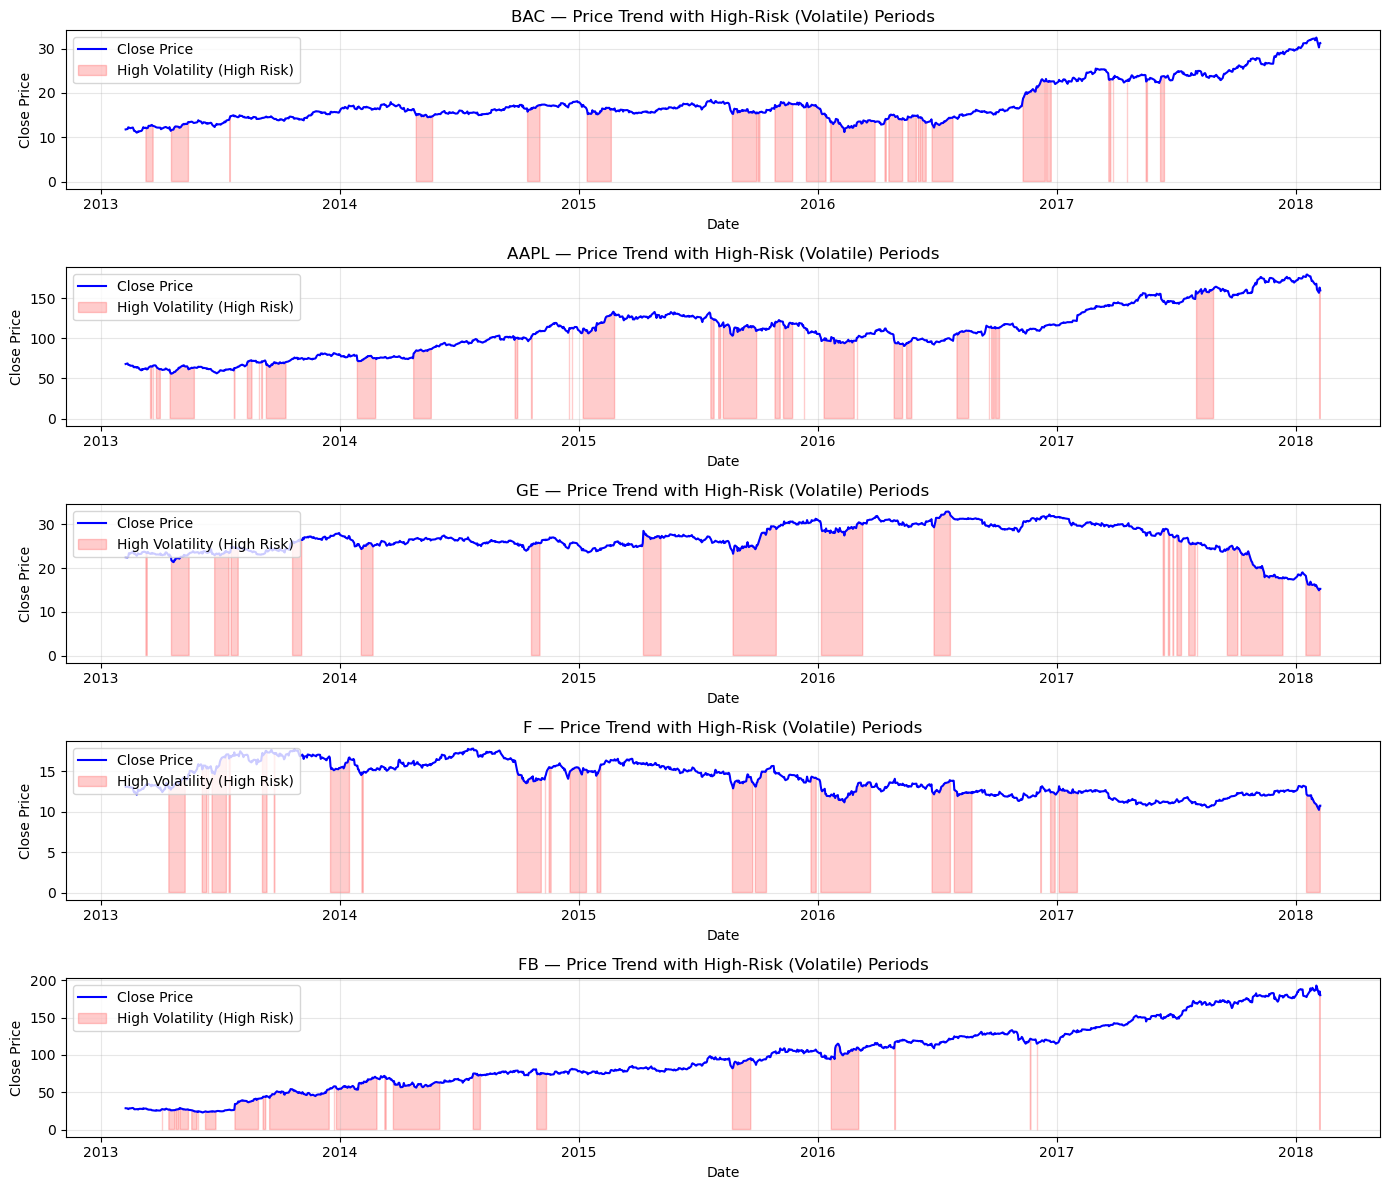

In [ ]:
plt.figure(figsize=(14, 12))

for i, stock in enumerate(top5, 1):
    stock_df = df_clean[df_clean['Name'] == stock].copy()

    # Define threshold for high volatility (top 25% of 20-day volatility)
    threshold = stock_df['volatility_20'].quantile(0.75)
    stock_df['High_Risk'] = stock_df['volatility_20'] > threshold

    plt.subplot(len(top5), 1, i)
    plt.plot(stock_df['date'], stock_df['close'], label='Close Price', color='blue')

    # Highlight high volatility zones
    plt.fill_between(
        stock_df['date'],
        stock_df['close'],
        where=stock_df['High_Risk'],
        color='red',
        alpha=0.2,
        label='High Volatility (High Risk)'
    )

    plt.title(f"{stock} — Price Trend with High-Risk (Volatile) Periods")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend(loc='upper left')
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Red shaded areas mark periods of market turbulence or uncertainty.

Frequent or extended red zones → higher risk exposure for that stock.

Stocks with smoother curves and fewer red areas are more stable.

Helps identify which stocks are riskier and when volatility spikes occurred (useful for strategy timing or feature interpretation).bold text

In [29]:
df_clean.head()

,date,open,high,low,close,volume,Name,SMA_20,SMA_50,RSI_14,daily_return,volatility_20,volatility_50
0,2013-02-08,45.07,45.35,45.00,45.08,1824755,A,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-11,45.17,45.18,44.45,44.60,2915405,A,NaN,NaN,NaN,-0.010648,NaN,NaN
2,2013-02-12,44.81,44.95,44.50,44.62,2373731,A,NaN,NaN,NaN,0.000448,NaN,NaN
3,2013-02-13,44.81,45.24,44.68,44.75,2052338,A,NaN,NaN,NaN,0.002913,NaN,NaN
4,2013-02-14,44.72,44.78,44.36,44.58,3826245,A,NaN,NaN,NaN,-0.003799,NaN,NaN


### 4. Time Features

day_of_week : Stock prices often follow weekly patterns, so this helps the model capture day-specific trends.

is_month_end : Market behavior can change at the end of the month due to regular reporting and trading activity, making this a useful indicator.

is_quarter_end : A quarter is defined as a group of three months. Every company prepares its quarterly results and publishes them publicly so, that people can analyze the company's performance. These quarterly results affect the stock prices heavily which is why we have added this feature because this can be a helpful feature for the learning model.

In [30]:
# Ensure date column is datetime
df_clean['date'] = pd.to_datetime(df_clean['date'])
df_clean = df_clean.sort_values(['Name', 'date'])


df_clean['day_of_week'] = df_clean['date'].dt.dayofweek
df_clean['is_month_end'] = df_clean['date'].dt.is_month_end.astype(int)
df_clean['is_quarter_end'] = np.where(df_clean['date'].dt.month % 3 == 0, 1, 0)

C:\Users\LapStore\AppData\Local\Temp\ipykernel_25420\4026650649.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='daily_return', data=avg_return_by_day, palette='coolwarm')
C:\Users\LapStore\AppData\Local\Temp\ipykernel_25420\4026650649.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_month_end', y='daily_return', data=avg_return_by_monthend, palette='mako')
C:\Users\LapStore\AppData\Local\Temp\ipykernel_25420\4026650649.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_quarter_end', y='daily_return'

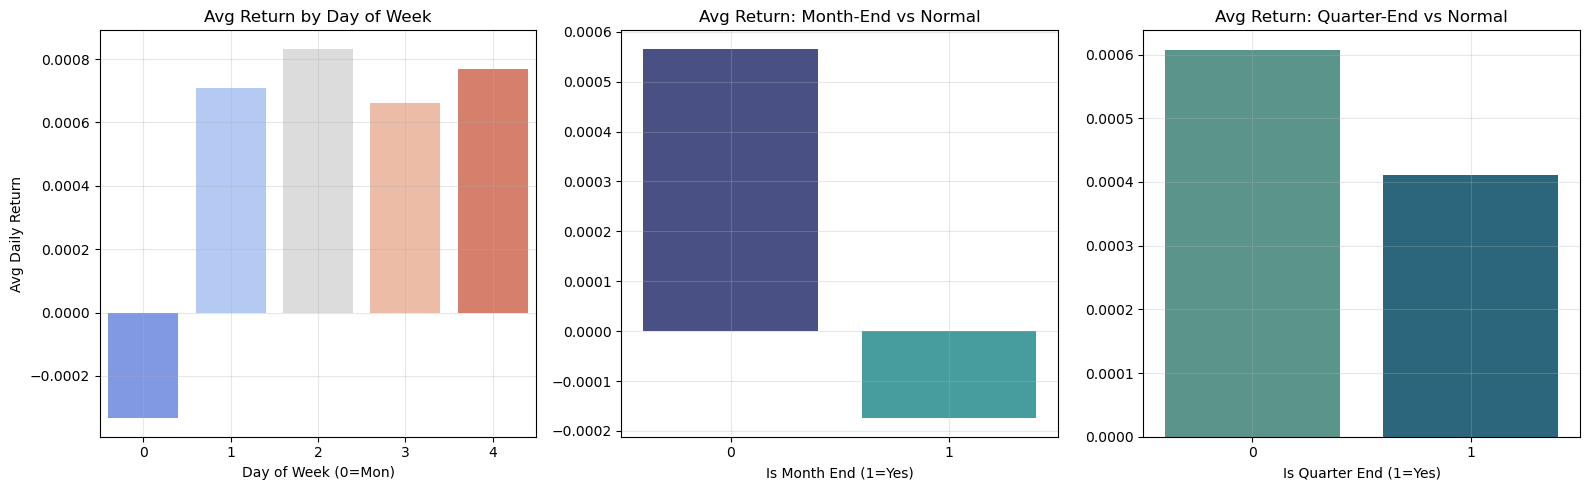

In [31]:
# Calculate average daily return by weekday, month-end, and quarter-end
avg_return_by_day = df_clean.groupby('day_of_week')['daily_return'].mean().reset_index()
avg_return_by_monthend = df_clean.groupby('is_month_end')['daily_return'].mean().reset_index()
avg_return_by_quarterend = df_clean.groupby('is_quarter_end')['daily_return'].mean().reset_index()

# Dashboard layout
plt.figure(figsize=(16,5))

# ---- Plot 1: Day of Week ----
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='daily_return', data=avg_return_by_day, palette='coolwarm')
plt.title('Avg Return by Day of Week')
plt.xlabel('Day of Week (0=Mon)')
plt.ylabel('Avg Daily Return')
plt.grid(alpha=0.3)

# ---- Plot 2: Month End ----
plt.subplot(1, 3, 2)
sns.barplot(x='is_month_end', y='daily_return', data=avg_return_by_monthend, palette='mako')
plt.title('Avg Return: Month-End vs Normal')
plt.xlabel('Is Month End (1=Yes)')
plt.ylabel('')
plt.grid(alpha=0.3)

# ---- Plot 3: Quarter End ----
plt.subplot(1, 3, 3)
sns.barplot(x='is_quarter_end', y='daily_return', data=avg_return_by_quarterend, palette='crest')
plt.title('Avg Return: Quarter-End vs Normal')
plt.xlabel('Is Quarter End (1=Yes)')
plt.ylabel('')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


The visualizations above reveal meaningful temporal patterns in stock returns:

Day-of-Week Effect: Returns tend to be slightly negative on Mondays and higher midweek (especially Tuesday–Thursday). This pattern aligns with the well-documented “Monday effect”, where markets open lower after the weekend due to accumulated uncertainty or negative sentiment.

Month-End Behavior: Returns often decline near the end of each month, possibly reflecting portfolio rebalancing and profit-taking by institutional investors preparing for reporting cycles.

Quarter-End Effect: Returns are generally lower at quarter-end, a common result of institutional adjustments (known as window dressing) that influence short-term price movements.

Overall, these patterns indicate that calendar-based factors—though subtle—carry predictive information about market behavior and can enhance model performance when combined with technical indicators such as SMA, RSI, and volatility.

### 4. next_day_return & Target

In [32]:
# Calculate Column
# Sort by date , name first
df_clean  = df_clean.sort_values(['Name', 'date']).reset_index(drop=True)

# Calculate next day's close-to-close return
df_clean['Next_Day_Return'] = df_clean.groupby('Name')['close'].pct_change().shift(-1)

# Drop last row (no next day)
df_clean = df_clean.dropna(subset=['Next_Day_Return'])


#  classification target (up=1, down=0)
df_clean['target_updown'] = (df_clean['Next_Day_Return'] > 0).astype(int)


#### Checking whether the target is balanced or not using a pie chart.

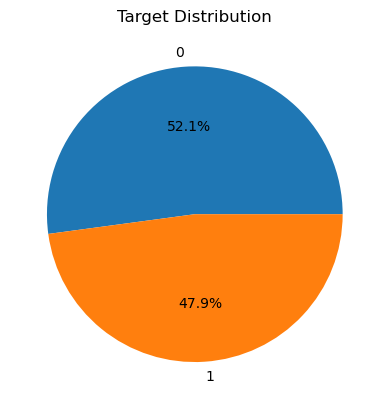

In [33]:
plt.pie(df_clean['target_updown'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.title('Target Distribution')
plt.show()

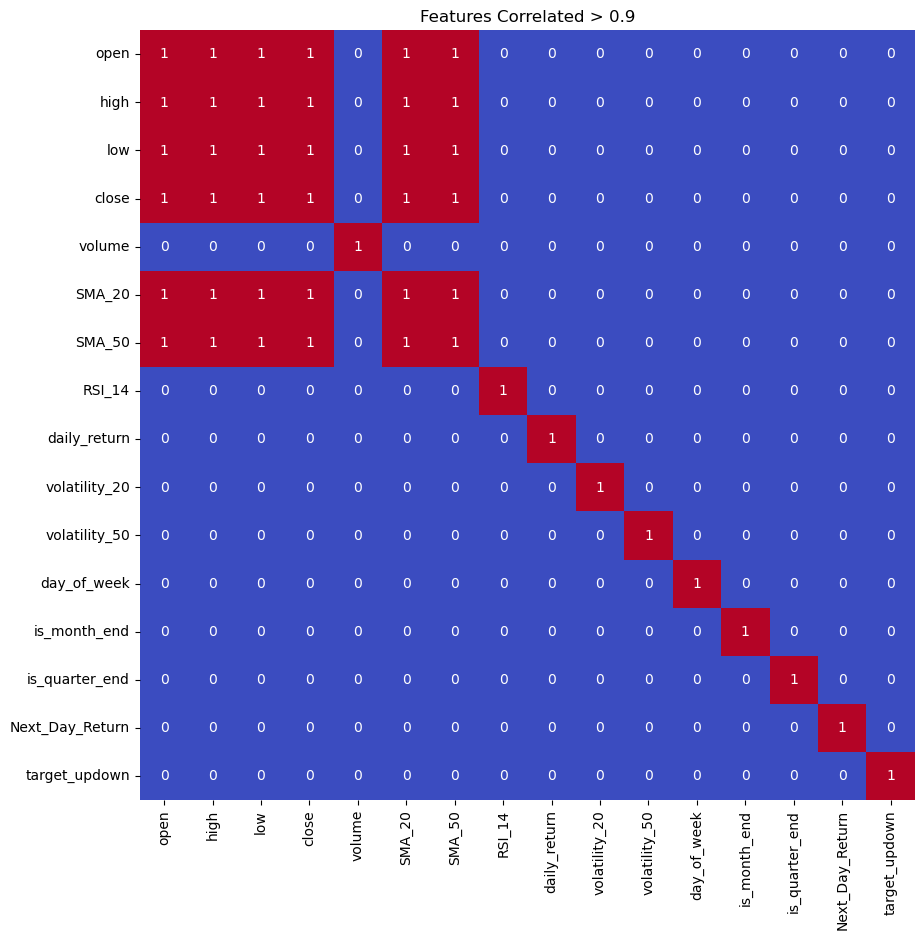

In [34]:
# Compute correlation matrix (excluding non-numeric columns like 'date' and 'Name')
corr_matrix = df_clean.drop(['date', 'Name'], axis=1).corr()

# Plot heatmap for correlations greater than 0.9
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix > 0.9, annot=True, cbar=False, cmap='coolwarm')
plt.title("Features Correlated > 0.9")
plt.show()

From the above heatmap, we can say that there is a high correlation between (open , close , high , low) columns (also SMA_20/SMA_50 correlate with OHLC), that is pretty obvious, and the added features are not highly correlated with each other or the orignal features which means that we are good to go and build our model.

In [35]:
df_clean.tail()

,date,open,high,low,close,volume,Name,SMA_20,SMA_50,RSI_14,daily_return,volatility_20,volatility_50,day_of_week,is_month_end,is_quarter_end,Next_Day_Return,target_updown
619023,2018-01-31,78.49,78.77,76.54,76.73,4136360,ZTS,76.1745,73.5588,55.523748,-0.020676,0.010624,0.008072,2,1,0,0.014206,1
619024,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS,76.4605,73.6994,60.311655,0.014206,0.010895,0.008247,3,0,0,-0.013364,0
619025,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS,76.6730,73.8160,54.304799,-0.013364,0.011539,0.008526,4,0,0,-0.038421,0
619026,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS,76.6965,73.8654,41.637053,-0.038421,0.014584,0.010210,0,0,0,-0.007585,0
619027,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS,76.6480,73.9094,39.741833,-0.007585,0.014423,0.010256,1,0,0,0.008052,1


In [36]:
df_clean.isnull().sum()

date                   0
open                   0
high                   0
low                    0
close                  0
volume                 0
Name                   0
SMA_20              9595
SMA_50             24739
RSI_14              7070
daily_return         505
volatility_20      10100
volatility_50      25243
day_of_week            0
is_month_end           0
is_quarter_end         0
Next_Day_Return        0
target_updown          0
dtype: int64

In [37]:
df_clean = df_clean.dropna()

In [38]:
df_clean.head()

,date,open,high,low,close,volume,Name,SMA_20,SMA_50,RSI_14,daily_return,volatility_20,volatility_50,day_of_week,is_month_end,is_quarter_end,Next_Day_Return,target_updown
50,2013-04-23,42.21,42.8425,42.13,42.61,3522419,A,42.1015,42.3832,50.731971,0.018160,0.018079,0.016046,1,0,0,0.005632,1
51,2013-04-24,42.72,43.0350,42.37,42.85,3020692,A,42.1530,42.3482,52.292814,0.005632,0.017766,0.016011,2,0,0,-0.002800,0
52,2013-04-25,43.05,43.2500,42.66,42.73,2119838,A,42.1850,42.3104,51.415723,-0.002800,0.017747,0.016013,3,0,0,-0.033466,0
53,2013-04-26,42.44,42.5700,40.69,41.30,5283798,A,42.1515,42.2414,42.308783,-0.033466,0.019337,0.016657,4,0,0,0.003874,1
54,2013-04-29,41.64,41.6800,41.05,41.46,2541961,A,42.1780,42.1790,43.514328,0.003874,0.018497,0.016671,0,0,0,-0.000482,0


In [39]:
df_clean.shape

(593281, 18)

# Machine Learning Model Development and Optimization

We will Do Classification using:

🥇 **LightGBM**	--> Best speed + accuracy combo on large datasets. Handles nonlinearity and imbalance beautifully.

🥈 **XGBoost** --> Very reliable, proven performance on stock-type problems, easy to interpret.

🥉 **Random Forest** -->	Great stable ensemble, simpler to tune, strong benchmark model.

In [40]:
class_features = [
    'volatility_20',
    'volatility_50',
    'SMA_20',
    'SMA_50',
    'RSI_14', 'day_of_week', 'is_month_end', 'is_quarter_end', 'daily_return']

df_clean['Target_UpDown'] = (df_clean['Next_Day_Return'] > 0).astype(int)


## LightGBM Classifier

In [41]:
pip install lightgbm


[LightGBM] [Info] Number of positive: 246773, number of negative: 227851
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 474624, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

<Figure size 1000x600 with 0 Axes>

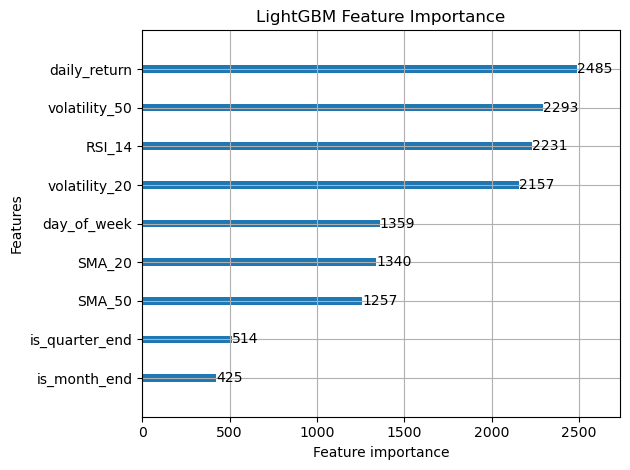

In [42]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df_clean[class_features]
y = df_clean['Target_UpDown']

# Split dataset (no shuffle for time-series data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ==========================
# LightGBM Classifier
# ==========================
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    class_weight='balanced',  # handle class imbalance
    random_state=42,
    n_jobs=-1                 # use all CPU cores
)

# Train the model
lgb_model.fit(X_train, y_train)

# Predict
y_pred = lgb_model.predict(X_test)

# ==========================
# Evaluation
# ==========================
print("=== LightGBM Evaluation ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ==========================
# Feature Importance Plot
# ==========================
plt.figure(figsize=(10,6))
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='split')
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.show()


## XGBoost Classifier

In [43]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


c:\Users\LapStore\anaconda4\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:41:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost Evaluation ===
Accuracy: 0.5349
Confusion Matrix:
[[29218 27520]
 [27667 34252]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.51      0.51     56738
           1       0.55      0.55      0.55     61919

    accuracy                           0.53    118657
   macro avg       0.53      0.53      0.53    118657
weighted avg       0.53      0.53      0.53    118657



<Figure size 1000x600 with 0 Axes>

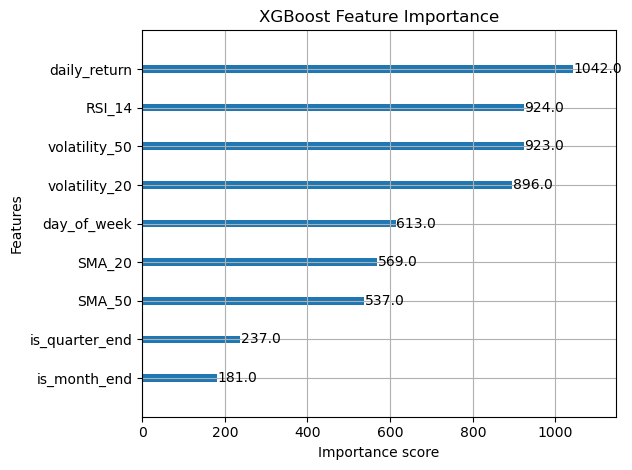

In [44]:
import xgboost as xgb


X = df_clean[class_features]
y = df_clean['Target_UpDown']

# Split dataset (no shuffle to preserve time-series order)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ==========================
# XGBoost Classifier
# ==========================
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),  # handle imbalance
    random_state=42,
    n_jobs=-1  # use all CPU cores
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# ==========================
# Evaluation
# ==========================
print("=== XGBoost Evaluation ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ==========================
# Feature Importance Plot
# ==========================
plt.figure(figsize=(10,6))
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()


## Random Forest Classifier

=== Random Forest Evaluation ===
Accuracy: 0.5283
Confusion Matrix:
[[30154 26584]
 [29392 32527]]

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.53      0.52     56738
           1       0.55      0.53      0.54     61919

    accuracy                           0.53    118657
   macro avg       0.53      0.53      0.53    118657
weighted avg       0.53      0.53      0.53    118657



C:\Users\LapStore\AppData\Local\Temp\ipykernel_25420\3571831791.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_model.feature_importances_, y=class_features, palette="viridis")


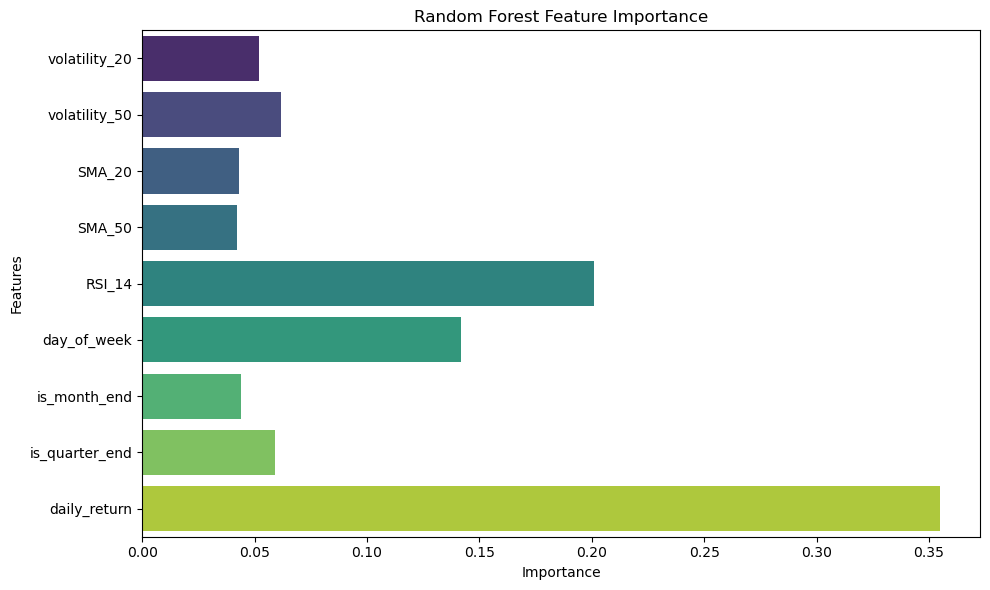

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier


X = df_clean[class_features]
y = df_clean['Target_UpDown']

# Split the dataset (no shuffle to preserve time-series order)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ==========================
# Random Forest Classifier
# ==========================
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    class_weight='balanced',  # handle class imbalance
    random_state=42,
    n_jobs=-1                 # use all CPU cores
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# ==========================
# Evaluation
# ==========================
print("=== Random Forest Evaluation ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ==========================
# Feature Importance Plot
# ==========================
plt.figure(figsize=(10,6))
sns.barplot(x=rf_model.feature_importances_, y=class_features, palette="viridis")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


## Evaluating & Comparing Models

In [46]:
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings("ignore")

# PREPARE TEST SETS
# Classification target
# Make sure Target_UpDown exists in the classification test set
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    df_clean[class_features], df_clean['Target_UpDown'], test_size=0.2, shuffle=False
)


# CLASSIFICATION PREDICTIONS
y_pred_rf_clf = rf_model.predict(X_test_clf)
y_pred_xgb_clf = xgb_model.predict(X_test_clf)
y_pred_lgbm_clf = lgb_model.predict(X_test_clf)


def evaluate_classification(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {"type": "classification", "model": model_name, "Accuracy": acc, "F1": f1}


# EVALUATE MODELS

clf_results = [
    evaluate_classification("Random Forest Classifier", y_test_clf, y_pred_rf_clf),
    evaluate_classification("XGBoost Classifier", y_test_clf, y_pred_xgb_clf),
    evaluate_classification("LightGBM Classifier", y_test_clf, y_pred_lgbm_clf)
]

# PRINT RESULTS

print("\n--- CLASSIFICATION RESULTS ---")
for c in clf_results:
    print(f"{c['model']}: /n Accuracy={c['Accuracy']:.4f}, F1-score={c['F1']:.4f}")

# SELECT BEST MODEL

best_clf = max(clf_results, key=lambda x: x['F1'])

print(f"Best Classification Model: {best_clf['model']} (F1={best_clf['F1']:.4f})")

# Overall recommendation
if best_clf['F1'] > 0.51:  # threshold to prefer classification
    print(f"\n✅ RECOMMENDATION: Use classification model: {best_clf['model']}")



--- CLASSIFICATION RESULTS ---
Random Forest Classifier: /n Accuracy=0.5283, F1-score=0.5285
XGBoost Classifier: /n Accuracy=0.5349, F1-score=0.5349
LightGBM Classifier: /n Accuracy=0.5351, F1-score=0.5351
Best Classification Model: LightGBM Classifier (F1=0.5351)

✅ RECOMMENDATION: Use classification model: LightGBM Classifier


## Hyperparameter Tuning For best model (LightGBM)

In [47]:
# HYPERPARAMETER TUNING FOR LIGHTGBM CLASSIFIER (BEST MODEL)

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


# TimeSeriesSplit preserves time order
tscv = TimeSeriesSplit(n_splits=3)

# Define parameter grid
lgb_clf_params = {
    'n_estimators': [200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'class_weight': ['balanced']
}

# GridSearchCV for tuning
grid_lgb_clf = GridSearchCV(
    lgb.LGBMClassifier(random_state=42),
    param_grid=lgb_clf_params,
    scoring='f1_weighted',
    cv=tscv,
    n_jobs=-1
)

# Fit to the classification training set
grid_lgb_clf.fit(X_train_clf, y_train_clf)

# Get the best estimator and parameters
best_lgb_clf = grid_lgb_clf.best_estimator_
print("✅ Best LightGBM parameters:", grid_lgb_clf.best_params_)


[LightGBM] [Info] Number of positive: 246773, number of negative: 227851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 474624, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
✅ Best LightGBM parameters: {'class_weight': 'balanced', 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}


### Evaluating Tuned LightGBM Model

In [48]:
# Predicting on the test set
y_pred = best_lgb_clf.predict(X_test_clf)

# Classification metrics
print(classification_report(y_test_clf, y_pred))
print("Accuracy:", accuracy_score(y_test_clf, y_pred))


              precision    recall  f1-score   support

           0       0.51      0.51      0.51     56738
           1       0.56      0.56      0.56     61919

    accuracy                           0.54    118657
   macro avg       0.54      0.53      0.53    118657
weighted avg       0.54      0.54      0.54    118657

Accuracy: 0.5360240019552155


**Observation:**  
After hyperparameter tuning, the LightGBM classifier’s accuracy improved slightly from 0.535 to 0.536, which slightly improved the model's ability to predict stock movements directions.


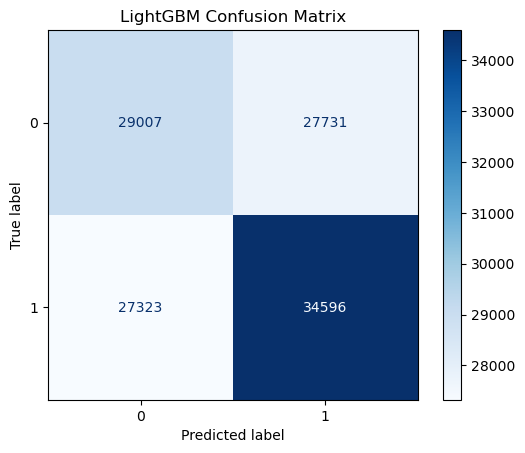

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(
    best_lgb_clf,
    X_test_clf,
    y_test_clf,
    cmap='Blues',       # color map
    normalize=None
)
plt.title("LightGBM Confusion Matrix")
plt.show()


**Insight:**
The hyperparameter-tuned LightGBM model shows a balanced performance between predicting downward (0) and upward (1) stock movements.

Out of 56,738 actual downward days, 29,007 were correctly predicted, while 27,731 were misclassified as upward. For the 61,919 actual upward days, 34,596 were correctly predicted, and 27,323 were misclassified as downward.

This indicates the model has **moderate predictive ability**, slightly better at identifying upward movements, but still makes a high number of misclassifications for both classes.


# Deployment

In [50]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [51]:
import joblib
joblib.dump(best_clf, "model.pkl")

['model.pkl']

In [52]:
#df_clean.to_csv("stocks.csv", index=False)


In [62]:
import joblib
model_obj = joblib.load("model.pkl")
print(model_obj)


{'type': 'classification', 'model': 'LightGBM Classifier', 'Accuracy': 0.5350716771871866, 'F1': 0.5350635474480198}


In [63]:
model_obj = model_obj['model']


In [65]:
import joblib

# Correct: save the trained model
joblib.dump(best_lgb_clf, "model.pkl")


['model.pkl']

In [66]:

model_obj = joblib.load("model.pkl")  # this should be the actual trained model

In [68]:
model_obj

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=7,
               n_estimators=200, random_state=42)